The goal is to allow students to determine if they should apply for a masters program or not.

Loading relevant libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_csv('Admission_Predict_Ver1.1.csv')
raw_data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
raw_data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

No null values

In [4]:
data = raw_data.copy()
#We can drop the Serial No. column as it is just an index.
data = data.drop(['Serial No.'],axis=1)
#Clean the title of 'Chance of Admit ' to 'Chance of Admit'
data = data.rename(columns={'Chance of Admit ':'Chance of Admit'})
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


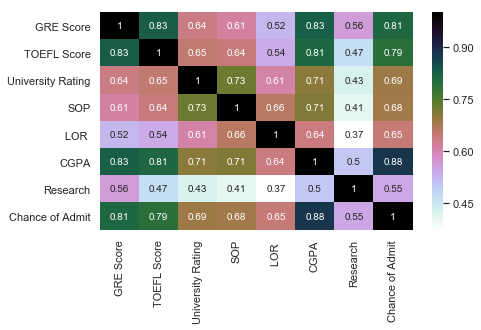

In [5]:
plt.figure(figsize=(7,4)) 
sns.heatmap(data.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(data.corr())
plt.show()

## Observations
GRE/TOEFL, GRE/CGPA, GRE/Chance of Admit are highly correlated.
TOEFL/CGPA, TOEFL/Chance of Admit are highly correlated
CGPA/Chance of Admit are highly correlated

Research has very low correlation with other variables as almost all students have the same answer.

In [6]:
x = data[['GRE Score', 'TOEFL Score','CGPA']]
y = data['Chance of Admit']

In [7]:
reg = LinearRegression()
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Calculate R squared

In [8]:
reg.score(x,y)

0.8046166796554792

### Caclulate adj R Squared

In [9]:
def adj_r2(x,y):
    r2 = reg.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [10]:
adj_r2(x,y)

0.8034349257017825

### Looking at our correlation table, University Rating has the next highest correlation with Chance of admit

In [11]:
#Remove university rating
x1 = data[['GRE Score', 'TOEFL Score','CGPA', 'University Rating']]

In [12]:
reg = LinearRegression()
reg.fit(x1,y)
reg.score(x1,y)

0.8091989054446624

In [13]:
adj_r2(x1,y)

0.8076570784179526

r^2 and adj r^2 both increased slightly implying we are not penalized for adding another variable

### Calculate univariate p values

In [14]:
from sklearn.feature_selection import f_regression
f_regression(x1,y)

(array([ 952.4917137 ,  839.36006853, 1751.85042916,  452.8946661 ]),
 array([1.08840369e-117, 6.72992676e-109, 3.39654486e-165, 5.86625563e-072]))

In [15]:
p_values = f_regression(x1,y)[1]
p_values

array([1.08840369e-117, 6.72992676e-109, 3.39654486e-165, 5.86625563e-072])

In [16]:
p_values.round(3)

array([0., 0., 0., 0.])

In [17]:
reg_summary = pd.DataFrame(data = x1.columns.values, columns=['Features'])
reg_summary ['Coefficients'] = reg.coef_
reg_summary ['p-values'] = p_values.round(3)
reg_summary

,Features,Coefficients,p-values
0,GRE Score,0.002268,0.0
1,TOEFL Score,0.002756,0.0
2,CGPA,0.132461,0.0
3,University Rating,0.012014,0.0


### Features are significant if the p-value is less than 0.05

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x1)
x_scaled = scaler.transform(x1)

In [22]:
reg = LinearRegression()
# We just need to specify that our inputs are the 'scaled inputs'
reg.fit(x_scaled,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
reg_summary = pd.DataFrame([['Bias'],['GRE Score'],['TOEFL Score'],['CGPA'],['University Rating']], columns=['Features'])

# Then we create and fill a second column, called 'Weights' with the coefficients of the regression
# Since the standardized coefficients are called 'weights' in ML, this is a much better word choice for our case
# Note that even non-standardized coeff. are called 'weights' 
# but more often than not, when doing ML we perform some sort of scaling
reg_summary['Weights'] = reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3]
reg_summary

,Features,Weights
0,Bias,0.721740
1,GRE Score,0.025589
2,TOEFL Score,0.016744
3,CGPA,0.080034
4,University Rating,0.013724


# Observations:
- The order of the weights are:
    - Bias, CGPA, GRE, TOEFL, University Rating
- The bias is the intercept